In [1]:
from dotenv import load_dotenv
load_dotenv("./.env", override=True)

True

In [2]:
from pydantic_settings import BaseSettings

class ModelConfig(BaseSettings):
    MISTRAL_API_KEY: str
    MODEL_NAME: str
    TEMPERATURE: float

In [3]:
from langchain_mistralai.chat_models import ChatMistralAI

In [4]:
class MistralChatModel(ChatMistralAI):
    def __init__(self, config: ModelConfig):
        super().__init__(
            model_name=config.MODEL_NAME,
            api_key=config.MISTRAL_API_KEY,
            temperature=config.TEMPERATURE,
        )

### STATE

In [5]:
from pydantic import BaseModel

class ClaimState(BaseModel):
    claim_file: str
    policy_file: str
    claim_text: str
    policy_terms: str
    evidence: str
    decision: str

#### Raw Extraction

In [6]:
from pdf2image import convert_from_path
from pypdf import PdfReader
import pytesseract
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate


In [7]:
def extract_raw_text(file_path: str):
    """Extract both digital text and OCR text from PDF."""

    try:

        loader = PdfReader(file_path)
        pages = loader.pages
        text = "\n".join([page.extract_text() for page in pages])

    except Exception:
        text = ""

    try:
        ocr = convert_from_path(file_path)
        ocr_text = "\n".join([pytesseract.image_to_string(page) for page in ocr])
    except Exception:
        ocr_text = ""

    return text, ocr_text

### Nodes

In [16]:
def text_extraction(digital_text: str, ocr_text: str) -> str:
    """Extract relevant text from the raw text."""

    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template("You are an document normalizer."),
        HumanMessagePromptTemplate.from_template(
            """Extract and normalize the text from the following document.

            Digital Text:
            {digital_text}

            OCR Text:
            {ocr_text}

            Task:
            - Merge both into a clean, deduplicated, logically ordered text.
            - DO not lose important details.
            - keep page context aligned.
            
            Return a single plain text output."""
        )
    ])

    chat = MistralChatModel(ModelConfig())
    lcel = (
        prompt
        | chat
    )

    response = lcel.invoke({
        "digital_text": digital_text,
        "ocr_text": ocr_text,
    })

    return response.content

def claim_text_extraction_node(state: ClaimState) -> ClaimState:
    digital_text, ocr_text = extract_raw_text(state.claim_file)
    state.claim_text = text_extraction(digital_text, ocr_text)
    return state

def policy_text_extraction_node(state: ClaimState) -> ClaimState:
    digital_text, ocr_text = extract_raw_text(state.policy_file)
    state.policy_terms = text_extraction(digital_text, ocr_text)
    return state

def cross_check_node(state: ClaimState) -> ClaimState:
    """Cross-check the claim against the policy terms."""

    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template("You are an insurance claim assessor."),
        HumanMessagePromptTemplate.from_template(
            """Given the following policy terms and claim details, assess whether the claim is valid.
            ignore policy numbers and dates.

            Policy Terms:
            {policy_terms}

            Claim Details:
            {claim_text}

            Task:
            - Identify any discrepancies or violations of the policy terms.
            - Provide evidence from both the policy and claim details to support your assessment.
            - Conclude whether the claim should be approved or denied.

            Return a detailed assessment including evidence and final decision."""
        )
    ])

    chat = MistralChatModel(ModelConfig())
    lcel = (
        prompt
        | chat
    )

    response = lcel.invoke({
        "policy_terms": state.policy_terms,
        "claim_text": state.claim_text,
    })

    state.evidence = response.content
    if "approve" in response.content.lower():
        state.decision = "Approved"
    elif "deny" in response.content.lower():
        state.decision = "Denied"
    else:
        state.decision = "Undecided"

    return state


In [17]:
from langgraph.graph import StateGraph, START, END

In [18]:
workflow = StateGraph(
    state_schema=ClaimState   
)

workflow.add_node("claim_text_extraction", claim_text_extraction_node)
workflow.add_node("policy_text_extraction", policy_text_extraction_node)
workflow.add_node("cross_check", cross_check_node)

workflow.add_edge(START, "claim_text_extraction")
workflow.add_edge("claim_text_extraction", "policy_text_extraction")
workflow.add_edge("policy_text_extraction", "cross_check")
workflow.add_edge("cross_check", END)

graph = workflow.compile()

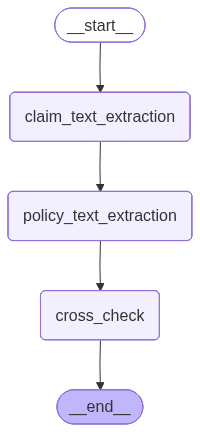

In [19]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
claim_document_path = "./mock_claim_approvable.pdf"
policy_document_path = "./mock_policy_detailed.pdf"

initial_state = ClaimState(
    claim_file=claim_document_path,
    policy_file=policy_document_path,
    claim_text="",
    policy_terms="",
    evidence="",
    decision="",
    raw_text=""
)


In [21]:
responce = graph.invoke(initial_state)

In [22]:
responce

{'claim_file': './mock_claim_approvable.pdf',
 'policy_file': './mock_policy_detailed.pdf',
 'claim_text': '---\n**INSURANCE CLAIM FORM**\n\n**CLAIMANT INFORMATION**\n**Name:** Priya Sharma\n**Policy Number:** HL12378945\n**Contact:**\n- Phone: 9876543210\n- Email: priya.sharma@example.com\n\n**INCIDENT DETAILS**\n**Date of Incident:** 05 July 2025\n**Location:** Apollo Hospital, Chennai\n**Type of Incident:** Hospitalization due to dengue fever\n\n**MEDICAL & EXPENSE DETAILS**\n**Hospital Stay:** 5 days (05 July 2025 – 10 July 2025)\n**Expenses Incurred:** ₹85,000 (Rupees Eighty-Five Thousand)\n**Bills Attached:** Yes (scanned copies provided)\n\n**DECLARATION**\nI hereby declare that the information provided is true and accurate.\n\n**Signature:** Priya Sharma\n---',
 'policy_terms': '```\n---\n**Insurance Policy Document**\n\n**Policy ID:** P98765\n**Plan:** Health Secure Plus - Individual\n\n**Coverage Benefits:**\n- In-patient hospitalization expenses (including room rent, nursing

In [23]:
import pprint
pprint.pprint(responce)


{'claim_file': './mock_claim_approvable.pdf',
 'claim_text': '---\n'
               '**INSURANCE CLAIM FORM**\n'
               '\n'
               '**CLAIMANT INFORMATION**\n'
               '**Name:** Priya Sharma\n'
               '**Policy Number:** HL12378945\n'
               '**Contact:**\n'
               '- Phone: 9876543210\n'
               '- Email: priya.sharma@example.com\n'
               '\n'
               '**INCIDENT DETAILS**\n'
               '**Date of Incident:** 05 July 2025\n'
               '**Location:** Apollo Hospital, Chennai\n'
               '**Type of Incident:** Hospitalization due to dengue fever\n'
               '\n'
               '**MEDICAL & EXPENSE DETAILS**\n'
               '**Hospital Stay:** 5 days (05 July 2025 – 10 July 2025)\n'
               '**Expenses Incurred:** ₹85,000 (Rupees Eighty-Five Thousand)\n'
               '**Bills Attached:** Yes (scanned copies provided)\n'
               '\n'
               '**DECLARATION**\n'
           